# Developing an integration routine.

In this notebook, I develop a struct and methods that 
describe wiener processes, their refinement, and integration with respect to said wiener process.

I then use that to integrate a single stochastic path.

In [1]:
using Random, Plots
import Statistics
using LinearAlgebra

In [2]:
T = 1.0
N = 25000
Δt = T/N

4.0e-5

In [3]:
struct WienerProcess
    #the two key things to know are 
    path::Vector{Float64}
    Δt::Float64
   
    #This creates a wiener process using a given path, while 
    #enforcing the invariant that a WienerProcess starts at zero
    WienerProcess(p,d) = p[1] != 0.0 ? new(vcat(0.0,p),d) : new(p,d)
end

In [4]:
#Adding methods (not as member functions though)
function get_steps(p::WienerProcess)
    #This pulls the steps out of the WienerProcess
    len = length(p.path)
    if p.path[1] != 0.0
        error("test")
    end 
    steps = p.path[2:len] - p.path[1:len-1]
end

function refine(p::WienerProcess)
    #This refines the resolution of the given WienerProcess, and returns another in it's stead
    len = length(p.path)
    arr = zeros(2*len-1)
    
    for ind in 1:len-1
        arr[2*ind-1] = p.path[ind]
        arr[2*ind] =  (0.5 * (p.path[ind] + p.path[ind+1]) .+ (((√p.Δt)/2)*randn(1)))[1]
    end
    arr[2*len-1] = p.path[len]
    
    return WienerProcess(arr, p.Δt/2)
end

function spread_walk(walk)
    len = length(walk)
    arr = zeros(2*len-1)
    
    for ind in 1:len-1
        arr[2*ind-1] = walk[ind]
        arr[2*ind] =  (0.5 * (walk[ind] + walk[ind+1]) ) 
    end
    arr[2*len-1] = walk[len]
    
    return arr
end

spread_walk (generic function with 1 method)

In [5]:
#Generators
function WienerProcess(size::Int, domain_length::Float64)
    #This function builds a wiener process out of randomly drawn steps
    #it uses the domain length to calculate Δt
    
    #TODO: implement checking for begining with zero
    return WienerProcess(cumsum(randn(size)),domain_length/size)
end

WienerProcess

In [6]:
function integrate(f::Function, wp::WienerProcess)
    #This function integrates across the time domain.
    
    sum = 0
    steps = get_steps(wp)
    
    for i in 1:length(wp.path)-1
        sum += f(wp.path[i]) * (steps[i]) 
    end
    
    return sum
end

integrate (generic function with 1 method)

In [55]:
#Generate a WienerProcess
tp = WienerProcess(N,T)

WienerProcess([0.0, 1.0969615061870517, 1.6263880871612335, 2.6531931022665294, 1.799795416658844, 2.915852202744025, 3.3135345174448307, 5.301426443331192, 5.271376090772383, 4.877675095770677  …  -113.35483208125206, -113.85394304976751, -113.84306318168005, -114.72031523889557, -116.321479444718, -116.74441520338651, -117.62147163351482, -118.46132702860086, -118.63593108769986, -118.30538192070581], 4.0e-5)

In [56]:
#test functions
slf(x) = x
unit(x) = 1

unit (generic function with 1 method)

Integrate $f(W_t) = 1$

In [57]:
integrate(unit,tp),tp.path[length(tp.path)]

(-118.30538192070581, -118.30538192070581)

In [58]:
rtp = refine(tp)
integrate(unit,rtp),rtp.path[length(rtp.path)]

(-118.30538192070581, -118.30538192070581)

# Answering the question given
integrate $f(W_t) = W_t$, refining the partition as you go.

In [63]:
function time_refinements(tp, itt = 10)
    iterated_test = tp
    
    refinements = []
    symbolic_integrals = []
    
    for iteration in 1:itt
        iterated_test = refine(iterated_test)
        append!(refinements, iterated_test)

        integral = @time integrate(slf,iterated_test)

        path_length = length(iterated_test.path)
        las_value = iterated_test.path[path_length]
        symbolic_integral = 0.5 * (las_value^2 - T )

        #Get the values needed of the 
        append!(symbolic_integrals, symbolic_integral)
        
        println("iteration ",iteration, ". Number of discrete points ", path_length)
        println("\t",integral, " " , symbolic_integral)
        println("\tAbsolute Error: ", abs(integral - symbolic_integral))
        println("\tSquared Error: ",(integral - symbolic_integral)^2)
        println("\tPercentage Error: ",(integral - symbolic_integral)/symbolic_integral, "\n")
    end
    return refinements, symbolic_integrals
end

time_refinements (generic function with 2 methods)

In [64]:
evaluated_values = [@time time_refinements(tp, 10) for x=1:4]

LoadError: MethodError: no method matching length(::WienerProcess)
Closest candidates are:
  length(!Matched::Plots.GridLayout) at /home/will2/.julia/packages/Plots/vsE7b/src/layouts.jl:261
  length(!Matched::JSON.Parser.MemoryParserState) at /home/will2/.julia/packages/JSON/3rsiS/src/Parser.jl:28
  length(!Matched::Base.EnvDict) at env.jl:132
  ...

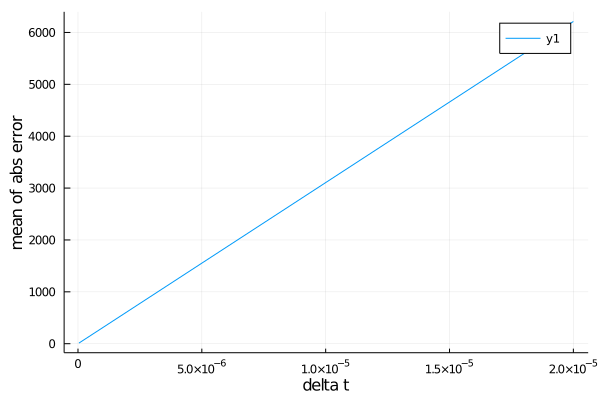

In [46]:
#plot(strong_convergence[1][2],Statistics.mean([x[1] for x=strong_convergence])
#    ,yaxis = "mean of abs error"
#    ,xaxis = "delta t")

# Finding the expectation and the variance


In [13]:
observed_paths = [WienerProcess(N,T) for i=1:3000];

In [14]:
evaluated_integrals = [integrate(slf,x) for x=observed_paths];

In [15]:
println("Observed mean: ", Statistics.mean(evaluated_integrals)
    ,"\nObserved var: ", Statistics.var(evaluated_integrals))

Observed mean: 51.05623680643159
Observed var: 3.080876369185244e8


In [16]:
#plot(0.0:Δt:T,[x.path for x=observed_paths[1:10]]
#    , legend=false)